# Step 2: Clean Up Data

In the previous step, the data was explored and it was found that the patterns in the data are quite different for each vendor. Therefore, in this notebook the data is cleaned up and analyzed for a specific vendor - Seagate. Seagate is chosen because it forms the majority in the backblaze dataset (~7M out of ~9M points).

The clean up in this notebook mainly consists of removing/replacing NaN values intelligently.

In [1]:
import gc
import pdb

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# register progress bar for compute calls in dask so we have an estimate of how long task will take
pbar = ProgressBar()
pbar.register()

In [3]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [4]:
# read all the data into one dataframe
df = dd.read_csv("/home/kachauha/Downloads/data_Q4_2018/*.csv", dtype=custom_dtypes)

In [ ]:
# get the seagate data
seagate_df = df[df['model'].str.startswith('S')]

In [11]:
# get the serial numbers for all the failed hard drives
failed_serials = seagate_df[seagate_df['failure']==1]['serial_number'].compute()
failed_serials.head()

[########################################] | 100% Completed | 46.2s


24449    S2ZYJ9CFC01460
29978          Z305B8DE
38504          ZA10CTP4
38544          ZA114N2J
40880          ZCH0CLFQ
Name: serial_number, dtype: object

**NOTE:** Can also add date of failure, and its model to failed_serials (and working_serials) if it will be helpful for preprocessing in the future.

In [15]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
# multiple entries will exist per serial number since it will be a time series. get only the last one
working_serials = seagate_df[~seagate_df['serial_number'].isin(failed_serials)]\
                    ['serial_number']\
                    .drop_duplicates(keep='last')\
                    .compute()
working_serials.head()

[########################################] | 100% Completed | 51.3s


2203    Z300XGTR
4389    Z300XA99
4900    Z3015BTR
6971    Z300WWNK
8459    Z30149AZ
Name: serial_number, dtype: object

**NOTE:** We can probably get away with not calculating working serials and instead using not failed_serials for indexing. this will be much faster and efficient since we are searching in ~300 drives as oppospsed to ~80k drives.

## Ensure Unique Indices

Having a unique index per entry (e.g. 2018-10-01 Z305B2QN) will make data processing less prone to errors. It will also expand the variety of merging and groupby operations that can be done on the data while still keeping it a dask dataframe (vs pandas dataframe). This is because some operations in dask require do not support duplicate indices.

In [6]:
# are there any duplicate indices? [SPOILER ALERT] yes
# tmp = seagate_df.index.compute()
# tmp.duplicated().any()    # True

# can reset indices do the job?
# no. see dask docs. indices are duplicated across dask partitions
seagate_df = seagate_df.reset_index(drop=True)

# tmp = seagate_df.index.compute()
# tmp.duplicated().any()    # True

In [10]:
# proof of duplicate indices
seagate_df.loc[0, :].compute()

[########################################] | 100% Completed | 43.0s


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2018-10-01,Z305B2QN,ST4000DM000,4.000787e+12,0.0,117.0,148579464.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-02,Z305B2QN,ST4000DM000,4.000787e+12,0.0,119.0,221256152.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-03,Z305B2QN,ST4000DM000,4.000787e+12,0.0,109.0,23013144.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-04,Z305B2QN,ST4000DM000,4.000787e+12,0.0,118.0,170005368.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-05,Z305B2QN,ST4000DM000,4.000787e+12,0.0,119.0,221968208.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-06,Z305B2QN,ST4000DM000,4.000787e+12,0.0,112.0,47067256.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-07,Z305B2QN,ST4000DM000,4.000787e+12,0.0,114.0,74388288.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-08,Z305B2QN,ST4000DM000,4.000787e+12,0.0,116.0,101959384.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-09,Z305B2QN,ST4000DM000,4.000787e+12,0.0,117.0,152439600.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-10-10,Z305B2QN,ST4000DM000,4.000787e+12,0.0,114.0,68581864.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**RESULT:** There does not seem to be a way to remove duplication. It will limit ops in some ways, but we'll have to get around them.

## Manual Feature Selection

Previous work done in this area strongly suggests not all stats are equally important. Backblaze suggests five, wikipedia suggests nine, and IBM research suggests a bunch. Make a superset of all these stats and work with those for now. Using too many features can be a rabbit hole we don't wanna go down in.

In [17]:
# work with critical columns for now
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242] # NOTE: 201 is all nans
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

## Find Patterns in NaNs and Cleaning Accordingly

**TODO:** unsure of reason for nans in 195, 191, 189crit, 184crit

In [18]:
# these are the columns analyzed and nans are accounted for these (see https://trello.com/c/tjFl6RHf)
done_stats = [2, 8, 11, 196, 223, 225, 250, 251, 252, 16, 17, 168, 170, 173, 174, 177, 218, 231, 232, 233, 235, 254,
             183, 200, 195, 191]
done_cols = ['smart_{}_raw'.format(i) for i in done_stats] + ['smart_{}_normalized'.format(i) for i in done_stats]

# the columns to keep for analysis
keep_cols = ['date', 'serial_number', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized

In [19]:
# meta data for later use
num_total_datapts = dd.compute(seagate_df.shape[0])

# copy of df on which to perform cleaning tasks
clean_df = seagate_df[keep_cols]

[########################################] | 100% Completed | 44.8s


In [20]:
# how bad is the nan situation for critical columns? get counts as a percent of total
seagate_nanpercent = clean_df.isna().sum().compute() / num_total_datapts

###################################################################
# # this chunk of code is used to get cols with the same percent of
# # nan values
# val = None
# for k, v in seagate_nanpercent.iteritems():
#     if v > 0.999197 and v < 0.999199:
#         if val is None:
#             val = v
#         print(k)
#         print(v)
#         if v == val:
#             print('same as val')
#         else:
#             print('different')
###################################################################

# show only values which are not all nans
seagate_nanpercent[seagate_nanpercent!=1].sort_values(ascending=False)

[########################################] | 100% Completed | 45.2s


smart_196_raw           0.992316
smart_196_normalized    0.992316
smart_189_normalized    0.351816
smart_184_normalized    0.351816
smart_184_raw           0.351816
smart_189_raw           0.351816
smart_193_raw           0.007853
smart_193_normalized    0.007853
smart_240_raw           0.007820
smart_240_normalized    0.007820
smart_188_normalized    0.007797
smart_187_normalized    0.007797
smart_190_normalized    0.007797
smart_188_raw           0.007797
smart_190_raw           0.007797
smart_187_raw           0.007797
smart_241_raw           0.007750
smart_241_normalized    0.007750
smart_242_normalized    0.007750
smart_242_raw           0.007750
smart_10_normalized     0.000113
smart_5_raw             0.000113
smart_7_raw             0.000113
smart_10_raw            0.000113
smart_198_normalized    0.000113
smart_198_raw           0.000113
smart_197_normalized    0.000113
smart_7_normalized      0.000113
smart_5_normalized      0.000113
smart_197_raw           0.000113
smart_194_

### Part 1: Drop Columns Where Most Entries Are Nan

In [ ]:
# drop columns that are all nans. NOTE: dropna on axis=1 is not supported in dask yet
MAJORITY_THRESHOLD = 0.99
clean_df = clean_df.drop(seagate_nanpercent[seagate_nanpercent > MAJORITY_THRESHOLD].index, axis=1)

### Part 2: Drop The Small Amount Of Rows Which Are Nans in Big Amount of Columns

In [23]:
# get the data points where 193 is null. inspect it for patterns
nan193_df = clean_df[clean_df['smart_193_raw'].isna()].compute()

# number of nans in this subset as a percentage of nans in the overall data
(nan193_df.isna().sum() / num_total_datapts).sort_values(ascending=False)

smart_193_normalized    0.007853
smart_193_raw           0.007853
smart_240_raw           0.007797
smart_240_normalized    0.007797
smart_184_raw           0.007797
smart_187_raw           0.007797
smart_188_raw           0.007797
smart_190_normalized    0.007797
smart_189_normalized    0.007797
smart_188_normalized    0.007797
smart_187_normalized    0.007797
smart_184_normalized    0.007797
smart_189_raw           0.007797
smart_190_raw           0.007797
smart_241_raw           0.007727
smart_241_normalized    0.007727
smart_242_normalized    0.007727
smart_242_raw           0.007727
smart_10_normalized     0.000113
smart_5_raw             0.000113
smart_7_raw             0.000113
smart_10_raw            0.000113
smart_198_normalized    0.000113
smart_197_normalized    0.000113
smart_7_normalized      0.000113
smart_5_normalized      0.000113
smart_197_raw           0.000113
smart_198_raw           0.000113
smart_194_normalized    0.000043
smart_1_normalized      0.000043
smart_194_

In [65]:
# number of wokring vs failed in overall df
seagate_df['failure'].value_counts().compute()

[########################################] | 100% Completed | 45.4s


0.0    7151837
1.0        341
Name: failure, dtype: int64

In [25]:
# number of working vs failed drives in subset
nan193_df['failure'].value_counts()

0.0    56151
1.0       13
Name: failure, dtype: int64

In [27]:
# do the failed drives report nans on the last day? - get num of obs we have for failed sers
sers = nan193_df[nan193_df['failure']==1]['serial_number']
nan193_df[nan193_df['serial_number'].isin(sers)]['serial_number'].value_counts()

S2ZYJ9FG404837    77
S2ZYJ9GGB00954    67
S2ZYJ9CG108008    66
S2ZYJ9GGB00973    60
S2ZYJ9GGB00982    50
S2ZYJ9GF302351    49
S2ZYJ9GGB00967    40
S2ZYJ9DG701063    38
S2ZYJ9BF519210    38
S2ZYJ9GGB01034    31
S2ZYJ9KG927405    18
S2ZYJ9CG107997     8
S2ZYJ9CFC01460     1
Name: serial_number, dtype: int64

**RESULT:** All the nans in 1, 5, 7, 10, 187, 188, 190, 194, 197, 198 in the main dataset are coming from the subset of rows where 193 is null. And so do almost all of the nans in 240, 241, 242. Therefore, it makes sense to drop all such rows.

However, the caveat is that among these obs there are failure obs, which are EXTREMELY precious. Additionally, it is not the case that a failed drive reports nans only on the day it fails. So as a compromise, drop rows iff they do not belong to a drive that has failed.

In [28]:
# retain columns iff they belong to a working drive or have non null values for 193 (and 1, 5, 7 .. by extension)
clean_df = clean_df[~clean_df['smart_193_raw'].isna() | clean_df['serial_number'].isin(sers)]
clean_df.isna().sum().compute() / dd.compute(clean_df.shape[0])

[########################################] | 100% Completed | 47.3s
[########################################] | 100% Completed | 48.3s


date                    0.000000
serial_number           0.000000
capacity_bytes          0.000000
failure                 0.000000
smart_1_raw             0.000000
smart_5_raw             0.000000
smart_7_raw             0.000000
smart_10_raw            0.000000
smart_184_raw           0.346792
smart_187_raw           0.000077
smart_188_raw           0.000077
smart_189_raw           0.346792
smart_190_raw           0.000077
smart_193_raw           0.000077
smart_194_raw           0.000000
smart_197_raw           0.000000
smart_198_raw           0.000000
smart_240_raw           0.000100
smart_241_raw           0.000100
smart_242_raw           0.000100
smart_1_normalized      0.000000
smart_5_normalized      0.000000
smart_7_normalized      0.000000
smart_10_normalized     0.000000
smart_184_normalized    0.346792
smart_187_normalized    0.000077
smart_188_normalized    0.000077
smart_189_normalized    0.346792
smart_190_normalized    0.000077
smart_193_normalized    0.000077
smart_194_

In [ ]:
# collect garbage
del nan193_df
del sers
gc.collect()

### Part 3: Fill Dummy Value Where Nans Are Indicative Features

One reason for nans is that some attributes (Head Flying Hours, LBA written, LBA read) are not applicable to this specific type of drive (Momentus). In such cases, the model should know that there exist drives that do not have these values. So these observations cannot be dropped.

In [32]:
# get the data points where 240 is null. inspect it for patterns
nan240_df = clean_df[clean_df['smart_240_raw'].isna()].compute()

# number of nans in this subset as a percentage of nans in the original overall data
(nan240_df.isna().sum() / num_total_datapts).sort_values(ascending=False)

smart_242_normalized    0.000099
smart_242_raw           0.000099
smart_241_normalized    0.000099
smart_241_raw           0.000099
smart_240_raw           0.000099
smart_240_normalized    0.000099
smart_188_raw           0.000076
smart_190_normalized    0.000076
smart_189_normalized    0.000076
smart_188_normalized    0.000076
smart_187_normalized    0.000076
smart_184_normalized    0.000076
smart_189_raw           0.000076
smart_190_raw           0.000076
smart_193_raw           0.000076
smart_187_raw           0.000076
smart_184_raw           0.000076
smart_193_normalized    0.000076
smart_10_raw            0.000000
smart_194_normalized    0.000000
smart_7_raw             0.000000
smart_5_raw             0.000000
failure                 0.000000
capacity_bytes          0.000000
serial_number           0.000000
smart_1_raw             0.000000
smart_197_raw           0.000000
smart_194_raw           0.000000
smart_198_raw           0.000000
smart_198_normalized    0.000000
smart_197_

In [ ]:
# number of nans in this subset as a percentage of total data points in the subset
(nan240_df.isna().sum() / nan240_df.shape[0]).sort_values(ascending=False)

**RESULT:** The nans in this case could be filled with mean, mode, etc. But the reason nans exist is because these drives are somewhat different than others. Therefore it may be better to put a special dummy value (e.g. -100) to let the model know that the values of these attributes are na. Could also possibly add another boolean column to specify isna but this may be memory intensive.

In [34]:
# fill in dummy values
DUMMY_VALUE = -100
cols_to_fill = ['smart_240_raw', 'smart_240_normalized', 'smart_241_raw', 'smart_241_normalized', 'smart_242_raw', 'smart_242_normalized']

# must do it in for loop, dask does not like indexing with list
# plus, its not straightforward to mask isna of specific columns
for col in cols_to_fill:
    clean_df[col] = clean_df[col].mask(clean_df[col].isna(), DUMMY_VALUE)

# how are things after this part
clean_df.isna().sum().compute() / dd.compute(clean_df.shape[0])

[########################################] | 100% Completed | 48.5s
[########################################] | 100% Completed | 46.4s


date                    0.000000
serial_number           0.000000
capacity_bytes          0.000000
failure                 0.000000
smart_1_raw             0.000000
smart_5_raw             0.000000
smart_7_raw             0.000000
smart_10_raw            0.000000
smart_184_raw           0.346792
smart_187_raw           0.000077
smart_188_raw           0.000077
smart_189_raw           0.346792
smart_190_raw           0.000077
smart_193_raw           0.000077
smart_194_raw           0.000000
smart_197_raw           0.000000
smart_198_raw           0.000000
smart_240_raw           0.000000
smart_241_raw           0.000000
smart_242_raw           0.000000
smart_1_normalized      0.000000
smart_5_normalized      0.000000
smart_7_normalized      0.000000
smart_10_normalized     0.000000
smart_184_normalized    0.346792
smart_187_normalized    0.000077
smart_188_normalized    0.000077
smart_189_normalized    0.346792
smart_190_normalized    0.000077
smart_193_normalized    0.000077
smart_194_

In [35]:
del nan240_df
gc.collect()

2581

### Part 4: Tricky Nans

What's left to deal with is not straightforward. It makes up ~35% of data so it can't directly be filled with a dummy value without inspecting first. It cannot be removed because it is too big of a chunk

In [36]:
# get a subset of df to investigate the behavior of cols with too many nans - eg why is smart 2 mostly nans?
nan184_df = clean_df[['date', 'serial_number', 'smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']]

In [37]:
# general description of data in these rows
nan184_df[['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']].compute().describe()

[########################################] | 100% Completed |  1min  0.7s


,smart_184_raw,smart_184_normalized,smart_189_raw,smart_189_normalized
count,4.635527e+06,4.635527e+06,4.635527e+06,4.635527e+06
mean,3.828475e-03,9.999624e+01,6.583818e+00,9.905654e+01
std,3.652030e-01,3.652030e-01,5.047643e+02,5.412950e+00
min,0.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00
25%,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02
50%,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02
75%,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02
max,7.200000e+01,1.000000e+02,6.553500e+04,1.000000e+02


[########################################] | 100% Completed | 52.9s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09b6e80ac8>,
      dtype=object)

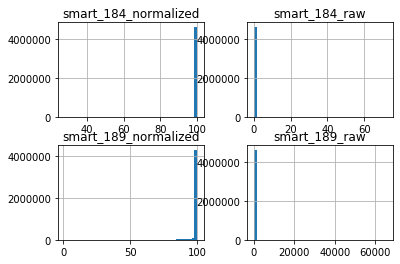

In [38]:
# hist to visualize anythign unusual
nan184_df[['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']].compute().hist(bins=50)

In [14]:
# get the data of the failed drives from the subset and see if there is any pattern in failed vs non failed
sub_failed = sub[['date', 'serial_number', 'smart_189_raw', 'smart_184_raw']][sub['serial_number'].isin(failed_serials['serial_number'])]
sub_working = sub[['date', 'serial_number', 'smart_189_raw', 'smart_184_raw']][sub['serial_number'].isin(working_serials['serial_number'])]

In [15]:
# are 184 and 189 simulataneously nan for all drives
(sub_failed['smart_184_raw'].isna() == sub_failed['smart_189_raw'].isna()).all().compute()

[########################################] | 100% Completed | 46.2s


True

In [16]:
# group by seriual numbers where nan values have occured, in the failed drives data
failed_nanserials = sub_failed[sub_failed['smart_189_raw'].isna()][['serial_number', 'smart_189_raw']].compute().groupby('serial_number')
failed_nanserials.head()

working_nanserials = sub_working[sub_working['smart_189_raw'].isna()][['serial_number', 'smart_189_raw']].compute().groupby('serial_number')
working_nanserials.head()

[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 47.1s


,serial_number,smart_189_raw
1,ZJV0XJQ4,NaN
2,ZJV0XJQ0,NaN
5,ZJV02XWG,NaN
6,ZJV1CSVX,NaN
7,ZJV02XWA,NaN
12,ZJV02XWV,NaN
22,ZCH0EBLP,NaN
28,ZJV0XJQR,NaN
35,ZJV0XJQA,NaN
40,ZJV0XJQL,NaN


In [17]:
# get the percentage of nans, within each group.
# this is to confirm a hunch - drives have either all values as nans or no values as nans 
# failed_nanpercent = seagate_df[seagate_df['serial_number'].isin(list(failed_nanserials.groups.keys()))][['serial_number', 'smart_184_normalized', 'smart_189_normalized']]
# failed_nanpercent = failed_nanpercent.groupby('serial_number').apply(lambda group: group.isna().sum() / group.shape[0])
failed_nanpercent = sub_failed.groupby('serial_number').apply(lambda group: group.isna().sum() / group.shape[0])

# working_nanpercent = seagate_df[seagate_df['serial_number'].isin(list(working_nanserials.groups.keys()))][['serial_number', 'smart_184_normalized', 'smart_189_normalized']]
# working_nanpercent = working_nanpercent.groupby('serial_number').apply(lambda group: group.isna().sum() / group.shape[0])
working_nanpercent = sub_working.groupby('serial_number').apply(lambda group: group.isna().sum() / group.shape[0])

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys


In [36]:
failed_nanpercent = failed_nanpercent.compute()
failed_nanpercent

[########################################] | 100% Completed |  1min  1.2s


,serial_number,smart_184_normalized,smart_189_normalized
serial_number,,,
ZCH06NAN,0.0,1.000000,1.000000
S2ZYJ9GGB00973,0.0,1.000000,1.000000
ZCH06GY8,0.0,1.000000,1.000000
ZCH04ZE9,0.0,1.000000,1.000000
ZJV0DJZN,0.0,1.000000,1.000000
ZCH0CDXG,0.0,1.000000,1.000000
S2ZYJ9BF519210,0.0,1.000000,1.000000
ZCH06ESZ,0.0,1.000000,1.000000
ZCH0CDC7,0.0,1.000000,1.000000


In [37]:
# failed_nanpercent[failed_nanpercent['smart_189_normalized'] != 1]    # S3010MAK, S3010LHR
# sub_failed[sub_failed['serial_number']=='S3010MAK']    # 1 nan value out of 19
# sub_failed[sub_failed['serial_number']=='S3010LHR']    # 1 nan value out of 14

In [18]:
working_nanpercent = working_nanpercent.compute()
working_nanpercent

[########################################] | 100% Completed |  1min 25.0s


,serial_number,smart_184_normalized,smart_189_normalized
serial_number,,,
S2ZYJ9AFA09514,0.0,1.00000,1.00000
Z4D05N47,0.0,0.01087,0.01087
ZCH018KV,0.0,1.00000,1.00000
ZCH028E0,0.0,1.00000,1.00000
ZCH028RH,0.0,1.00000,1.00000
ZCH036H8,0.0,1.00000,1.00000
ZCH0447E,0.0,1.00000,1.00000
ZCH046XA,0.0,1.00000,1.00000
ZCH050E0,0.0,1.00000,1.00000


In [34]:
# working_nanpercent[working_nanpercent['smart_189_normalized'] != 1]    # 87 values, max percent 0.011494/1.0
# tmp = sub_working[sub_working['serial_number']=='Z4D05N47'].compute()    # 1 nan value out of 92
# tmp = sub_working[sub_working['serial_number']=='S301090L'].compute()    # 1 nan value out of 87

In [12]:
def custom_col_fillna(group_col):
    """
    This is designed for 184 and 189 only. Needs to be extended.
    Assumes input is a column
    """
    # if a drive has always been reporting nans for a smart stat, fill it with a dummy value
    # otherwise interpolate for nans
    if group_col.isna().all():
        return group_col.fillna(value=-100)
    else:
        return group_col.interpolate(method='linear')

In [9]:
# res = seagate_df.drop(['date', 'model'], axis=1).groupby('serial_number').apply(custom_fillna)
# columns that need imputation
imputed_cols = seagate_df[['serial_number', 'smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']]
imputed_cols.head()

In [21]:
# make sure we have included all the data points from the original df
(imputed_cols.index == seagate_df.index).all().compute()

[########################################] | 100% Completed | 43.5s


True

In [13]:
# these can be brought into memory and transformed using pandas
# dask has some limitations on split-apply-combine
imputed_cols = imputed_cols.compute()
imputed_cols = imputed_cols.groupby('serial_number').transform(custom_col_fillna)

In [36]:
# make sure nan filling did not mess with indices
(imputed_cols.index == seagate_df.index).all()

[########################################] | 100% Completed | 44.1s


True

**RESULT** For a given serial number, either all values are nans or less than 1% values are nans (often only one). Therefore we can approach this in a hybrid way.

For all nan values, fill with dummy value so that model knows that a particular serial number does provides only nans for this smart stat.

For few nan values, interpolate because this likely has happened because of some hiccup in logging.

In [92]:
clean_df[clean_df['smart_190_normalized'].isna()]['serial_number'].value_counts().compute()

[########################################] | 100% Completed | 48.4s


S2ZYJ9FG404837    77
S2ZYJ9GGB00954    67
S2ZYJ9CG108008    66
S2ZYJ9GGB00973    60
S2ZYJ9GGB00982    50
S2ZYJ9GF302351    49
S2ZYJ9GGB00967    40
S2ZYJ9DG701063    38
S2ZYJ9BF519210    38
S2ZYJ9GGB01034    31
S2ZYJ9KG927405    18
S2ZYJ9CG107997     8
S2ZYJ9CFC01460     1
Name: serial_number, dtype: int64

In [55]:
def cond_fillna(group):
    if group['smart_184_raw'].isna().all():
        ret = group
        ret['smart_184_raw'] = -100
        return ret
    elif group['smart_184_raw'].isna().any():
        ret = group
        ret['smart_184_raw'].interpolate(method='linear')
        return ret
    else:
        return group
    
    
##################### WORKING BUT LESS ACCURATE #####################
# tmp = clean_df[clean_df['serial_number'].isin(['S2ZYJ9FG404837', 'S2ZYJ9CG107997', 'S2ZYJ9CFC01460'])]
# res = tmp[['serial_number', 'smart_184_raw']].groupby('serial_number').apply(lambda group: group.fillna(value=-100))
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.interpolate(method='linear'))
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.fillna(value=DUMMY_VALUE))
# res = res.groupby('serial_number').apply(lambda group: group.fillna(value=-100))
##################### WORKING BUT LESS ACCURATE #####################

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


In [123]:
# interpolate missing values. all-nan columns will be unaffected
clean_df = clean_df.groupby('serial_number').apply(lambda group: group.interpolate(method='linear'))

# fill with -100 for the values that are still nan
clean_df = clean_df.groupby('serial_number').apply(lambda group: group.fillna(value=-100))

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


In [56]:
# how are things after this part
tmp = clean_df.isna().sum().compute() / dd.compute(clean_df.shape[0])
tmp

[#################                       ] | 44% Completed |  2min 33.3s


ValueError: cannot reindex from a duplicate axis

## Time Series Static Representation

In [5]:
# TODO: could add days on, curtosis, modelname. remove span hardcoding
def get_ewm_attr(group):
    """
    Converts the input time series to a static representation
    I.e takes out the time dimension
    Uses exponentially weighted moving windows
    Returns the last element of mean and std calculated with exponentially weighed window
    """
    # select numeric type columns from the group and apply ewm stats on it
    # NOTE: boolean type columns may also be selected by adding 'bool' to select_dtypes parameter 'include'
    res = group.select_dtypes('number')\
                .ewm(span=20)\
                .agg(['mean', 'std'])
    
    # need to split multiindex columns into individual colunms
    # can also access the means by doing .xs('mean', axis=1, level=1)
    res.columns = ['_'.join(col) for col in res.columns]
    return res.iloc[-1, :]

In [6]:
foo = pd.DataFrame({'a': range(3), 
                    'b': range(3,0,-1),
                    'c': ['2018-10-01', '2018-10-02', '2018-10-03'],
                    'd': ['2018-10-01', '2018-10-03', '2018-10-02'],
                    'e': ['2018-10-03', '2018-10-02', '2018-10-01']})

print(foo['a'].is_monotonic)
print(foo['b'].is_monotonic)
print(foo['c'].is_monotonic)
print(foo['d'].is_monotonic)
print(foo['e'].is_monotonic)
foo.head()

True
False
True
False
False


,a,b,c,d,e
0,0,3,2018-10-01,2018-10-01,2018-10-03
1,1,2,2018-10-02,2018-10-03,2018-10-02
2,2,1,2018-10-03,2018-10-02,2018-10-01


In [36]:
# FIXME: assumes sorted group
# FIXME: does not work well with dask -- kurt values are off
def get_recent_attr(group):
    """
    Converts the input time series to a static representation
    I.e takes out the time dimension
    Returns the last element of mean and std calculated for the most recent 20 days
    """
    print('group of serial number', group['serial_number'])
    # if datafrmae is already sorted by date, just take the tail
    # otherwise we need to sort it to get the most recent days data
    if group['date'].is_monotonic:
        # select numeric type columns from the group and apply stats on it
        # NOTE: boolean type columns may also be selected by adding 'bool' to select_dtypes parameter 'include'
        recents = group.select_dtypes('number').tail(20)
    else:
        recents = group.sort_values(by='date').select_dtypes('number').tail(20)
    
    # get simple attributes
    means = recents.mean().add_prefix('mean_').to_frame().transpose()
    stds = recents.std().add_prefix('std_').to_frame().transpose()
    kurts = recents.kurt().add_prefix('kurt_').to_frame().transpose()

    # put attr together in one df
    res = pd.concat([means, stds, kurts], axis=1)
    
    # add number of days drive has bene active
    res['days'] = len(group)
    
    return res

### Test on two sample points

In [10]:
# 'Z30271GD'
curr_drive_stats = df[df['serial_number'].isin(['ZA10MCEQ', 'Z30271GD'])]\
                        .drop(['capacity_bytes', 'failure'], axis=1)
#                         .compute()
print(dd.compute(curr_drive_stats.shape))
curr_drive_stats.head()

((182, 127),)


/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/dask/dataframe/core.py:4634: UserWarning: Insufficient elements for `head`. 5 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,date,serial_number,model,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
99615,2018-10-01,ZA10MCEQ,ST8000DM002,82.0,171214352.0,NaN,NaN,94.0,0.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99635,2018-10-01,Z30271GD,ST4000DM000,117.0,161421224.0,NaN,NaN,92.0,0.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
grouped = curr_drive_stats.groupby('serial_number')
grouped_means = grouped.mean().compute().add_prefix('mean_')
grouped_stds = grouped.std().compute().add_prefix('std_')
grouped_days = grouped.size().compute().to_frame('days')
grouped_days.index.name = None    # to match the other agg results, so that it can be concatenated easily

# grouped_stats = grouped.apply(get_timeseries_attr)
# grouped_stats = grouped.apply(get_most_recent)
grouped_stats = pd.concat([grouped_means, grouped_stds, grouped_days], axis=1)
grouped_stats.head()

,mean_smart_1_normalized,mean_smart_1_raw,mean_smart_2_normalized,mean_smart_2_raw,mean_smart_3_normalized,mean_smart_3_raw,mean_smart_4_normalized,mean_smart_4_raw,mean_smart_5_normalized,mean_smart_5_raw,...,std_smart_250_raw,std_smart_251_normalized,std_smart_251_raw,std_smart_252_normalized,std_smart_252_raw,std_smart_254_normalized,std_smart_254_raw,std_smart_255_normalized,std_smart_255_raw,days
serial_number,,,,,,,,,,,,,,,,,,,,,
Z30271GD,115.978022,1.340394e+08,NaN,NaN,92.0,0.0,100.0,17.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
ZA10MCEQ,79.626374,1.229850e+08,NaN,NaN,94.0,0.0,100.0,3.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91


### Static-ify entire data

Models may have to be built vendor wise.
Hard drive model name will have to be converted to one hot encodings or groups. But drop it for now.

In [34]:
X_grouped = X.groupby('serial_number')
means = X_grouped.mean().compute().add_prefix('mean_')
stds = X_grouped.std().compute().add_prefix('std_')
days = X_grouped.size().compute().to_frame('days')
days.index.name = None    # to match the other agg results, so that it can be concatenated easily

In [35]:
# join stats into one df
X_train = pd.concat([means, stds, days], axis=1)
X_train.head()

,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_193_normalized,std_smart_194_normalized,std_smart_196_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_201_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,days
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ9H9,1.252961e+08,0.0,3.107040e+08,0.0,0.0,0.0,18.0,0.0,28.478261,346167.217391,...,0.0,0.730477,NaN,0.0,0.0,NaN,NaN,NaN,NaN,23
6VDHZAKY,1.346626e+08,0.0,3.117690e+08,0.0,0.0,0.0,19.0,0.0,29.000000,403482.695652,...,0.0,1.243163,NaN,0.0,0.0,NaN,NaN,NaN,NaN,23
6VDHZATY,2.070238e+08,0.0,4.240170e+08,0.0,0.0,0.0,8.0,0.0,25.000000,348260.000000,...,0.0,0.000000,NaN,0.0,0.0,NaN,NaN,NaN,NaN,2
6VDHZAXD,9.719883e+07,0.0,3.160235e+08,0.0,0.0,0.0,18.0,0.0,28.375000,364329.125000,...,0.0,1.784190,NaN,0.0,0.0,NaN,NaN,NaN,NaN,16
6VDHZB48,1.047900e+08,0.0,3.157392e+08,0.0,0.0,0.0,14.0,0.0,30.130435,409073.782609,...,0.0,1.713697,NaN,0.0,0.0,NaN,NaN,NaN,NaN,23


In [37]:
# first drop columns where all avalues are null
X_train.dropna(axis=1, how='all', inplace=True)

# then drop rows which still have nulls
X_train.dropna(how='any', inplace=False).shape
# X_train.isna().sum()

(0, 69)

In [16]:
# set y to 1 whereever it has failed, otherwise 0
Y_train = X_train.index.isin(failed_serials['serial_number'])

In [20]:
X_train.head()

,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_196_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,days
serial_number,,,,,,,,,,,,,,,,,,,,,


## Clustering - KMeans and Spectral

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import homogeneity_completeness_v_measure

from dask_ml.preprocessing import StandardScaler as dStandardScaler
from dask_ml.cluster import KMeans as dKMeans
from dask_ml.cluster import SpectralClustering as dSpectralClustering

In [18]:
# fit a vanilla kmeans++ model and see how it does
dkmeans = dKMeans(n_clusters=2, init='k-means++')
dkmeans.fit(X_train)

ValueError: Found array with 0 sample(s) (shape=(0, 69)) while a minimum of 1 is required.

In [ ]:
# confusion matrix. Cij represents amount known to be i but predicted as j
conf_mat = confusion_matrix(Y_train, dkmeans.labels_)
print('confusin matrix =\n', conf_mat)

# completeness - are data points of a given class in the same cluster
# homogeneity - do all clusters contain points which are members of a single class
# vmeasure - normalized completeness and homogeneity score
hom, com, v = homogeneity_completeness_v_measure(Y_train, dkmeans.labels_)
print('hom =', hom)
print('com =', com)
print('v =', v)

In [91]:
# spectral clustering in hopes of achieving non linear boundaries
dsc = dSpectralClustering(n_clusters=2, 
                          assign_labels=dKMeans(n_clusters=2, init='k-means++'),
                          persist_embedding=True,
                          random_state=42)
dsc.fit(grouped_stats)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Approach for EWM: Point by Point

In [5]:
# dask does not work well for this
# static_df = X.groupby('serial_number').apply(get_timeseries_attr).compute()

# will have to do manually in chunks
serials = X['serial_number'].unique().compute()
serials.head()

0          Z305B2QN
1          ZJV0XJQ4
2          ZJV0XJQ0
3    PL1331LAHG1S4H
4          ZA16NQJR
Name: serial_number, dtype: object

In [ ]:
# number of serial numbers whose data there will be in a chunk
CHUNK_SIZE = 500
static_df_chunks = []

for i in range(serials.shape[0] // CHUNK_SIZE + 1):
    print(i+1, 'out of', serials.shape[0] // CHUNK_SIZE)

    # get the chunk of serials for this iteration
    start_idx = i * CHUNK_SIZE
    end_idx = min(serials.shape[0], (i + 1) * CHUNK_SIZE)
    ser_chunk = serials.iloc[start_idx: end_idx]
    
    # get the data corresponding to serial numbers in this chunk
    # and group to get the time series and then extract its defining features
    foo = X[X['serial_number'].isin(ser_chunk)].compute()
    static_df_chunks.append(foo\
                               .groupby('serial_number')\
                               .apply(get_timeseries_attr))
    # alternative: get groups. do in parallel using numba for n,g in groups: apply

In [ ]:
# join the chunks together to make one whole df
static_df = pd.concat(static_df_chunks)   
static_df.to_csv('mvts_static_rep.csv')
static_df.head()

In [ ]:
pbar.unregister()